In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import glob, os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from bokeh.plotting import figure, show
from bokeh.palettes import Spectral4
# from bkcharts import TimeSeries, output_file, show
from bokeh.io import output_notebook
output_notebook()

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

Using TensorFlow backend.


Loading BokehJS ...

# Data Preparation

Data yang digunakan untuk pengujian ini dataset delay penerbangan kota New York pada bulan Januari 2019. Data ini awalnya terdapat 16 atribut. **CRS** berarti waktu yang sudah terjadwal, sedangkan **ACTUAL** berarti waktu yang sebenarnya terjadi. *Departure delay* berupa anga dalam satuan menit, bila data > 0 maka terjadi *delay*, bila data = 0 berarti keberangkatan tepat waktu, sedangkan data < 0 (atau negatif) berarti keberangkatan lebih awal.

In [2]:
data = pd.concat(map(pd.read_csv, glob.glob(os.path.join('dataset', '*.csv'))))

In [3]:
data.reset_index(inplace=True, drop=True)
data = data.drop(['Unnamed: 18'], axis=1)
data.shape

(756306, 18)

### Convert FL_DATE to datetime

In [4]:
data['FL_DATE'] = pd.to_datetime(data.FL_DATE)
# data['CRS_DEP_TIME'] = pd.to_datetime(data['CRS_DEP_TIME'], format='%H%M').dt.time
# data['FL_DATE'] +=  pd.to_timedelta(data.CRS_DEP_TIME.astype(str), unit='s')

### Split *CRS departure time* during 00:00 - 00:59

In [5]:
dropindex = []
for i in data.itertuples():
    x = len(str(i.CRS_DEP_TIME))
    if x == 2:
        dropindex.append(i.Index)
data1 = data.loc[dropindex]
data.drop(data.index[dropindex], inplace=True)
data1.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
124,2018-12-01,14107,"Phoenix, AZ",12478,"New York, NY",45,38.0,-7.0,721,710.0,-11.0,0.0,0.0,276.0,272.0,256.0,1.0,2153.0
257,2018-12-01,12892,"Los Angeles, CA",12478,"New York, NY",40,31.0,-9.0,900,854.0,-6.0,0.0,0.0,320.0,323.0,297.0,1.0,2475.0
3115,2018-12-02,12892,"Los Angeles, CA",12478,"New York, NY",40,33.0,-7.0,900,825.0,-35.0,0.0,0.0,320.0,292.0,258.0,1.0,2475.0
3708,2018-12-03,14107,"Phoenix, AZ",12478,"New York, NY",45,42.0,-3.0,721,708.0,-13.0,0.0,0.0,276.0,266.0,241.0,1.0,2153.0
3922,2018-12-03,12892,"Los Angeles, CA",12478,"New York, NY",40,35.0,-5.0,900,826.0,-34.0,0.0,0.0,320.0,291.0,271.0,1.0,2475.0


## Convert *CRS departure time* from int to time

In [6]:
data['CRS_DEP_TIME'] = pd.to_datetime(data['CRS_DEP_TIME'], format='%H%M').dt.time
data1['CRS_DEP_TIME'] = pd.to_datetime(data1['CRS_DEP_TIME'], format='%M').dt.time

### Merge *CRS departure time*

In [7]:
data = data.append(data1)
data.sort_index(inplace=True)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
0,2018-12-01,11193,"Cincinnati, OH",12478,"New York, NY",15:37:00,1535.0,-2.0,1734,1728.0,-6.0,0.0,0.0,117.0,113.0,93.0,1.0,589.0
1,2018-12-01,12953,"New York, NY",14492,"Raleigh/Durham, NC",13:30:00,1325.0,-5.0,1525,1514.0,-11.0,0.0,0.0,115.0,109.0,70.0,1.0,431.0
2,2018-12-01,10721,"Boston, MA",12478,"New York, NY",15:28:00,1520.0,-8.0,1658,1632.0,-26.0,0.0,0.0,90.0,72.0,46.0,1.0,187.0
3,2018-12-01,12953,"New York, NY",11996,"Greer, SC",09:30:00,920.0,-10.0,1201,1132.0,-29.0,0.0,0.0,151.0,132.0,104.0,1.0,610.0
4,2018-12-01,12953,"New York, NY",14122,"Pittsburgh, PA",09:35:00,931.0,-4.0,1127,1104.0,-23.0,0.0,0.0,112.0,93.0,62.0,1.0,335.0


In [8]:
data['FL_DATE'] +=  pd.to_timedelta(data.CRS_DEP_TIME.astype(str), unit='s')
data = data.sort_values(by='FL_DATE',ascending=True)
data.reset_index(inplace=True, drop=True)
data.head()
data.loc[data['DEP_TIME'] == 7]

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
53913,2018-12-27 23:59:00,12478,"New York, NY",10732,"Aguadilla, PR",23:59:00,7.0,8.0,445,438.0,-7.0,0.0,0.0,226.0,211.0,182.0,1.0,1576.0
62717,2019-01-01 23:59:00,11292,"Denver, CO",12478,"New York, NY",23:59:00,7.0,8.0,535,522.0,-13.0,0.0,0.0,216.0,195.0,173.0,1.0,1626.0
71594,2019-01-06 22:20:00,11278,"Washington, DC",14576,"Rochester, NY",22:20:00,7.0,107.0,2337,110.0,93.0,0.0,0.0,77.0,63.0,53.0,1.0,296.0
80233,2019-01-10 23:59:00,11292,"Denver, CO",12478,"New York, NY",23:59:00,7.0,8.0,540,544.0,4.0,0.0,0.0,221.0,217.0,187.0,1.0,1626.0
96539,2019-01-18 23:59:00,13891,"Ontario, CA",12478,"New York, NY",23:59:00,7.0,8.0,818,816.0,-2.0,0.0,0.0,319.0,309.0,285.0,1.0,2429.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668060,2019-10-17 22:46:00,12953,"New York, NY",11292,"Denver, CO",22:46:00,7.0,81.0,101,200.0,59.0,0.0,0.0,255.0,233.0,212.0,1.0,1620.0
699277,2019-11-02 23:55:00,14771,"San Francisco, CA",12478,"New York, NY",23:55:00,7.0,12.0,735,819.0,44.0,0.0,0.0,280.0,312.0,226.0,1.0,2586.0
726881,2019-11-15 23:59:00,14869,"Salt Lake City, UT",12478,"New York, NY",23:59:00,7.0,8.0,609,614.0,5.0,0.0,0.0,250.0,247.0,229.0,1.0,1990.0
732492,2019-11-18 19:59:00,12953,"New York, NY",11193,"Cincinnati, OH",19:59:00,7.0,248.0,2220,155.0,215.0,0.0,0.0,141.0,108.0,90.0,1.0,585.0


In [9]:
data.head(10)
data.shape[0]

756306

In [10]:
duplicated = data[data.duplicated(subset='FL_DATE', keep='first')]
duplicated.shape[0]

512873

In [11]:
data = data.drop_duplicates(subset='FL_DATE', keep='first')
data.reset_index(inplace=True, drop=True)

In [12]:
data.shape[0]
# data.head(10)

243433

### Check NaN

In [13]:
data.isna().sum()

FL_DATE                   0
ORIGIN_AIRPORT_ID         0
ORIGIN_CITY_NAME          0
DEST_AIRPORT_ID           0
DEST_CITY_NAME            0
CRS_DEP_TIME              0
DEP_TIME               5245
DEP_DELAY              5246
CRS_ARR_TIME              0
ARR_TIME               5684
ARR_DELAY              6428
CANCELLED                 0
DIVERTED                  0
CRS_ELAPSED_TIME          1
ACTUAL_ELAPSED_TIME    6428
AIR_TIME               6428
FLIGHTS                   0
DISTANCE                  0
dtype: int64

### Drop NaN and check again

In [14]:
data = data.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])
data.isna().sum()

FL_DATE                0
ORIGIN_AIRPORT_ID      0
ORIGIN_CITY_NAME       0
DEST_AIRPORT_ID        0
DEST_CITY_NAME         0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
FLIGHTS                0
DISTANCE               0
dtype: int64

### Calculate *Departure time* based on *Departure delay*

Because there is some error with value in DEP_DELAY column, so we need to calculate its value to make sure the value is right.

In [15]:
# Example, the value of departure delay is only 1 digit (7) 
# because int dtype cannot display 0 before integer. 
data.loc[1223]

FL_DATE                2018-12-03 02:59:00
ORIGIN_AIRPORT_ID                    14025
ORIGIN_CITY_NAME           Plattsburgh, NY
DEST_AIRPORT_ID                      11697
DEST_CITY_NAME         Fort Lauderdale, FL
CRS_DEP_TIME                      02:59:00
DEP_TIME                               313
DEP_DELAY                               14
CRS_ARR_TIME                           628
ARR_TIME                               644
ARR_DELAY                               16
CANCELLED                                0
DIVERTED                                 0
CRS_ELAPSED_TIME                       209
ACTUAL_ELAPSED_TIME                    211
AIR_TIME                               189
FLIGHTS                                  1
DISTANCE                              1334
Name: 1223, dtype: object

In [16]:
for row in data.itertuples():
    i = row.CRS_DEP_TIME
    j = row.DEP_DELAY
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    if j<0:
        d = dt.timedelta(minutes=abs(j))
        k = c - d
    else:
        d = dt.timedelta(minutes=j)
        k = c + d
    if row.DEP_TIME != k:
        data.at[row.Index, 'DEP_TIME'] = k

In [17]:
# data.loc[1609]
data.loc[1223]

FL_DATE                2018-12-03 02:59:00
ORIGIN_AIRPORT_ID                    14025
ORIGIN_CITY_NAME           Plattsburgh, NY
DEST_AIRPORT_ID                      11697
DEST_CITY_NAME         Fort Lauderdale, FL
CRS_DEP_TIME                      02:59:00
DEP_TIME                           3:13:00
DEP_DELAY                               14
CRS_ARR_TIME                           628
ARR_TIME                               644
ARR_DELAY                               16
CANCELLED                                0
DIVERTED                                 0
CRS_ELAPSED_TIME                       209
ACTUAL_ELAPSED_TIME                    211
AIR_TIME                               189
FLIGHTS                                  1
DISTANCE                              1334
Name: 1223, dtype: object

### Delete day on *Departure time*

In [18]:
to_str = []
for row in data.itertuples():
    i = len(str(row.DEP_TIME))
    if i != 8:
        to_str.append(row.Index)

In [19]:
data3 = data.loc[set(data.index) - set(to_str)]
data4 = data.loc[to_str]

data3['DEP_TIME'] = pd.to_datetime(data3['DEP_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data4['DEP_TIME'] = pd.to_datetime(data4['DEP_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [20]:
# data4.loc[1609]

### Merge

In [21]:
data = data3.append(data4)
data.head(3)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
94,2018-12-01 08:22:00,13930,"Chicago, IL",14576,"Rochester, NY",08:22:00,10:25:00,123.0,1058,1311.0,133.0,0.0,0.0,96.0,106.0,71.0,1.0,528.0
131,2018-12-01 09:35:00,10257,"Albany, NY",13204,"Orlando, FL",09:35:00,12:17:00,162.0,1238,1522.0,164.0,0.0,0.0,183.0,185.0,157.0,1.0,1073.0
138,2018-12-01 09:46:00,11066,"Columbus, OH",12953,"New York, NY",09:46:00,15:56:00,370.0,1130,1734.0,364.0,0.0,0.0,104.0,98.0,77.0,1.0,479.0


### Calculate CRS Arrival time based on CRS Elapsed time

Because there is some error with value in CRS_ARR_TIME column, so we need to calculate its value to make sure the value is right.

In [22]:
for row in data.itertuples():
    i = row.CRS_DEP_TIME
    j = row.CRS_ELAPSED_TIME
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    d = dt.timedelta(minutes=j)
    k = c + d
    if row.CRS_ARR_TIME != k:
        data.at[row.Index, 'CRS_ARR_TIME'] = k

In [23]:
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
94,2018-12-01 08:22:00,13930,"Chicago, IL",14576,"Rochester, NY",08:22:00,10:25:00,123.0,9:58:00,1311.0,133.0,0.0,0.0,96.0,106.0,71.0,1.0,528.0
131,2018-12-01 09:35:00,10257,"Albany, NY",13204,"Orlando, FL",09:35:00,12:17:00,162.0,12:38:00,1522.0,164.0,0.0,0.0,183.0,185.0,157.0,1.0,1073.0
138,2018-12-01 09:46:00,11066,"Columbus, OH",12953,"New York, NY",09:46:00,15:56:00,370.0,11:30:00,1734.0,364.0,0.0,0.0,104.0,98.0,77.0,1.0,479.0
141,2018-12-01 09:56:00,10397,"Atlanta, GA",14576,"Rochester, NY",09:56:00,10:08:00,12.0,12:02:00,1205.0,3.0,0.0,0.0,126.0,117.0,95.0,1.0,749.0
146,2018-12-01 10:01:00,11057,"Charlotte, NC",12478,"New York, NY",10:01:00,10:00:00,-1.0,12:00:00,1140.0,-20.0,0.0,0.0,119.0,100.0,78.0,1.0,541.0


In [24]:
to_str = []
for row in data.itertuples():
    i = len(str(row.CRS_ARR_TIME))
    if i != 8:
        to_str.append(row.Index)

In [25]:
data6 = data.loc[set(data.index) - set(to_str)]
data7 = data.loc[to_str]

data6['CRS_ARR_TIME'] = pd.to_datetime(data6['CRS_ARR_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data7['CRS_ARR_TIME'] = pd.to_datetime(data7['CRS_ARR_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [26]:
data = data6.append(data7)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
35,2018-12-01 06:40:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:40:00,06:42:00,2.0,12:12:00,1010.0,-2.0,0.0,0.0,332.0,328.0,279.0,1.0,1990.0
39,2018-12-01 06:47:00,11298,"Dallas/Fort Worth, TX",12953,"New York, NY",06:47:00,06:45:00,-2.0,10:03:00,1036.0,-27.0,0.0,0.0,196.0,171.0,154.0,1.0,1389.0
46,2018-12-01 06:59:00,12478,"New York, NY",14771,"San Francisco, CA",06:59:00,06:48:00,-11.0,13:37:00,1022.0,-15.0,0.0,0.0,398.0,394.0,367.0,1.0,2586.0
47,2018-12-01 07:00:00,12953,"New York, NY",11292,"Denver, CO",07:00:00,07:00:00,0.0,11:22:00,855.0,-27.0,0.0,0.0,262.0,235.0,216.0,1.0,1620.0
48,2018-12-01 07:02:00,14057,"Portland, OR",12478,"New York, NY",07:02:00,07:11:00,9.0,12:01:00,1533.0,32.0,0.0,0.0,299.0,322.0,300.0,1.0,2454.0


### Calculate Arrival time based on Arrival delay

Because there is some error with value in ARR_TIME column, so we need to calculate its value to make sure the value is right.

In [27]:
for row in data.itertuples():
    i = row.CRS_ARR_TIME
    j = row.ARR_DELAY
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    if j<0:
        d = dt.timedelta(minutes=abs(j))
        k = c - d
    else:
        d = dt.timedelta(minutes=j)
        k = c + d
    if row.ARR_TIME != k:
        data.at[row.Index, 'ARR_TIME'] = k

In [28]:
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
35,2018-12-01 06:40:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:40:00,06:42:00,2.0,12:12:00,12:10:00,-2.0,0.0,0.0,332.0,328.0,279.0,1.0,1990.0
39,2018-12-01 06:47:00,11298,"Dallas/Fort Worth, TX",12953,"New York, NY",06:47:00,06:45:00,-2.0,10:03:00,9:36:00,-27.0,0.0,0.0,196.0,171.0,154.0,1.0,1389.0
46,2018-12-01 06:59:00,12478,"New York, NY",14771,"San Francisco, CA",06:59:00,06:48:00,-11.0,13:37:00,13:22:00,-15.0,0.0,0.0,398.0,394.0,367.0,1.0,2586.0
47,2018-12-01 07:00:00,12953,"New York, NY",11292,"Denver, CO",07:00:00,07:00:00,0.0,11:22:00,10:55:00,-27.0,0.0,0.0,262.0,235.0,216.0,1.0,1620.0
48,2018-12-01 07:02:00,14057,"Portland, OR",12478,"New York, NY",07:02:00,07:11:00,9.0,12:01:00,12:33:00,32.0,0.0,0.0,299.0,322.0,300.0,1.0,2454.0


In [29]:
to_str = []
for row in data.itertuples():
    i = len(str(row.ARR_TIME))
    if i != 8:
        to_str.append(row.Index)

In [30]:
data8 = data.loc[set(data.index) - set(to_str)]
data9 = data.loc[to_str]

data8['ARR_TIME'] = pd.to_datetime(data8['ARR_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data9['ARR_TIME'] = pd.to_datetime(data9['ARR_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [31]:
data = data8.append(data9)
data.reset_index(inplace=True, drop=True)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
0,2018-12-01 05:35:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:35:00,05:30:00,-5.0,09:45:00,10:16:00,31.0,0.0,0.0,250.0,286.0,221.0,1.0,1389.0
1,2018-12-01 06:30:00,12391,"Islip, NY",13204,"Orlando, FL",06:30:00,08:03:00,93.0,09:25:00,10:59:00,94.0,0.0,0.0,175.0,176.0,147.0,1.0,971.0
2,2018-12-01 06:40:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:40:00,06:42:00,2.0,12:12:00,12:10:00,-2.0,0.0,0.0,332.0,328.0,279.0,1.0,1990.0
3,2018-12-01 06:59:00,12478,"New York, NY",14771,"San Francisco, CA",06:59:00,06:48:00,-11.0,13:37:00,13:22:00,-15.0,0.0,0.0,398.0,394.0,367.0,1.0,2586.0
4,2018-12-01 07:00:00,12953,"New York, NY",11292,"Denver, CO",07:00:00,07:00:00,0.0,11:22:00,10:55:00,-27.0,0.0,0.0,262.0,235.0,216.0,1.0,1620.0


### Working Day or not

In [32]:
data["DAY_TYPE"] = data.FL_DATE.apply(lambda x: 1 if x.dayofweek > 5 else 0)
data.head(3)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE
0,2018-12-01 05:35:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:35:00,05:30:00,-5.0,09:45:00,10:16:00,31.0,0.0,0.0,250.0,286.0,221.0,1.0,1389.0,0
1,2018-12-01 06:30:00,12391,"Islip, NY",13204,"Orlando, FL",06:30:00,08:03:00,93.0,09:25:00,10:59:00,94.0,0.0,0.0,175.0,176.0,147.0,1.0,971.0,0
2,2018-12-01 06:40:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:40:00,06:42:00,2.0,12:12:00,12:10:00,-2.0,0.0,0.0,332.0,328.0,279.0,1.0,1990.0,0


### Finding Federal Holidays

In [33]:
cal = calendar()
holidays = cal.holidays(start = data.FL_DATE.min(), end = data.FL_DATE.max())
data["IS_HOLIDAY"] = data.FL_DATE.isin(holidays)
data

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY
0,2018-12-01 05:35:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:35:00,05:30:00,-5.0,09:45:00,10:16:00,31.0,0.0,0.0,250.0,286.0,221.0,1.0,1389.0,0,False
1,2018-12-01 06:30:00,12391,"Islip, NY",13204,"Orlando, FL",06:30:00,08:03:00,93.0,09:25:00,10:59:00,94.0,0.0,0.0,175.0,176.0,147.0,1.0,971.0,0,False
2,2018-12-01 06:40:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:40:00,06:42:00,2.0,12:12:00,12:10:00,-2.0,0.0,0.0,332.0,328.0,279.0,1.0,1990.0,0,False
3,2018-12-01 06:59:00,12478,"New York, NY",14771,"San Francisco, CA",06:59:00,06:48:00,-11.0,13:37:00,13:22:00,-15.0,0.0,0.0,398.0,394.0,367.0,1.0,2586.0,0,False
4,2018-12-01 07:00:00,12953,"New York, NY",11292,"Denver, CO",07:00:00,07:00:00,0.0,11:22:00,10:55:00,-27.0,0.0,0.0,262.0,235.0,216.0,1.0,1620.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237000,2019-11-30 23:49:00,14869,"Salt Lake City, UT",12478,"New York, NY",23:49:00,00:09:00,20.0,03:59:00,04:24:00,25.0,0.0,0.0,250.0,255.0,234.0,1.0,1990.0,0,False
237001,2019-11-30 23:52:00,13796,"Oakland, CA",12478,"New York, NY",23:52:00,00:02:00,10.0,05:11:00,05:22:00,11.0,0.0,0.0,319.0,320.0,285.0,1.0,2576.0,0,False
237002,2019-11-30 23:55:00,12892,"Los Angeles, CA",12478,"New York, NY",23:55:00,00:15:00,20.0,05:17:00,05:31:00,14.0,0.0,0.0,322.0,316.0,267.0,1.0,2475.0,0,False
237003,2019-11-30 23:57:00,10140,"Albuquerque, NM",12478,"New York, NY",23:57:00,01:34:00,97.0,03:51:00,05:21:00,90.0,0.0,0.0,234.0,227.0,202.0,1.0,1826.0,0,False


### Departure from NY or Arrival to NY

In [34]:
data['DEP_FROM_NY'] = data.ORIGIN_CITY_NAME.apply(lambda x: 1 if x[-2:] == 'NY' else 0)
data.head(10)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY
0,2018-12-01 05:35:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:35:00,05:30:00,-5.0,09:45:00,10:16:00,31.0,0.0,0.0,250.0,286.0,221.0,1.0,1389.0,0,False,1
1,2018-12-01 06:30:00,12391,"Islip, NY",13204,"Orlando, FL",06:30:00,08:03:00,93.0,09:25:00,10:59:00,94.0,0.0,0.0,175.0,176.0,147.0,1.0,971.0,0,False,1
2,2018-12-01 06:40:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:40:00,06:42:00,2.0,12:12:00,12:10:00,-2.0,0.0,0.0,332.0,328.0,279.0,1.0,1990.0,0,False,1
3,2018-12-01 06:59:00,12478,"New York, NY",14771,"San Francisco, CA",06:59:00,06:48:00,-11.0,13:37:00,13:22:00,-15.0,0.0,0.0,398.0,394.0,367.0,1.0,2586.0,0,False,1
4,2018-12-01 07:00:00,12953,"New York, NY",11292,"Denver, CO",07:00:00,07:00:00,0.0,11:22:00,10:55:00,-27.0,0.0,0.0,262.0,235.0,216.0,1.0,1620.0,0,False,1
5,2018-12-01 07:02:00,14057,"Portland, OR",12478,"New York, NY",07:02:00,07:11:00,9.0,12:01:00,12:33:00,32.0,0.0,0.0,299.0,322.0,300.0,1.0,2454.0,0,False,0
6,2018-12-01 07:28:00,12953,"New York, NY",13303,"Miami, FL",07:28:00,07:25:00,-3.0,10:48:00,10:47:00,-1.0,0.0,0.0,200.0,202.0,153.0,1.0,1096.0,0,False,1
7,2018-12-01 07:35:00,14747,"Seattle, WA",12478,"New York, NY",07:35:00,07:31:00,-4.0,12:50:00,13:00:00,10.0,0.0,0.0,315.0,329.0,307.0,1.0,2422.0,0,False,0
8,2018-12-01 07:36:00,12478,"New York, NY",14986,"Sarasota/Bradenton, FL",07:36:00,07:26:00,-10.0,10:42:00,10:23:00,-19.0,0.0,0.0,186.0,177.0,156.0,1.0,1041.0,0,False,1
9,2018-12-01 07:38:00,12478,"New York, NY",13495,"New Orleans, LA",07:38:00,08:16:00,38.0,10:58:00,11:32:00,34.0,0.0,0.0,200.0,196.0,174.0,1.0,1182.0,0,False,1


### Previous Five Observations

In [35]:
for obs in range(1,6):
    data["T_" + str(obs)] = data.DEP_DELAY.shift(obs)

In [36]:
data.fillna(0.00,inplace=True)
data.head(10)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
0,2018-12-01 05:35:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",05:35:00,05:30:00,-5.0,09:45:00,10:16:00,31.0,0.0,0.0,250.0,286.0,221.0,1.0,1389.0,0,False,1,0.0,0.0,0.0,0.0,0.0
1,2018-12-01 06:30:00,12391,"Islip, NY",13204,"Orlando, FL",06:30:00,08:03:00,93.0,09:25:00,10:59:00,94.0,0.0,0.0,175.0,176.0,147.0,1.0,971.0,0,False,1,-5.0,0.0,0.0,0.0,0.0
2,2018-12-01 06:40:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:40:00,06:42:00,2.0,12:12:00,12:10:00,-2.0,0.0,0.0,332.0,328.0,279.0,1.0,1990.0,0,False,1,93.0,-5.0,0.0,0.0,0.0
3,2018-12-01 06:59:00,12478,"New York, NY",14771,"San Francisco, CA",06:59:00,06:48:00,-11.0,13:37:00,13:22:00,-15.0,0.0,0.0,398.0,394.0,367.0,1.0,2586.0,0,False,1,2.0,93.0,-5.0,0.0,0.0
4,2018-12-01 07:00:00,12953,"New York, NY",11292,"Denver, CO",07:00:00,07:00:00,0.0,11:22:00,10:55:00,-27.0,0.0,0.0,262.0,235.0,216.0,1.0,1620.0,0,False,1,-11.0,2.0,93.0,-5.0,0.0
5,2018-12-01 07:02:00,14057,"Portland, OR",12478,"New York, NY",07:02:00,07:11:00,9.0,12:01:00,12:33:00,32.0,0.0,0.0,299.0,322.0,300.0,1.0,2454.0,0,False,0,0.0,-11.0,2.0,93.0,-5.0
6,2018-12-01 07:28:00,12953,"New York, NY",13303,"Miami, FL",07:28:00,07:25:00,-3.0,10:48:00,10:47:00,-1.0,0.0,0.0,200.0,202.0,153.0,1.0,1096.0,0,False,1,9.0,0.0,-11.0,2.0,93.0
7,2018-12-01 07:35:00,14747,"Seattle, WA",12478,"New York, NY",07:35:00,07:31:00,-4.0,12:50:00,13:00:00,10.0,0.0,0.0,315.0,329.0,307.0,1.0,2422.0,0,False,0,-3.0,9.0,0.0,-11.0,2.0
8,2018-12-01 07:36:00,12478,"New York, NY",14986,"Sarasota/Bradenton, FL",07:36:00,07:26:00,-10.0,10:42:00,10:23:00,-19.0,0.0,0.0,186.0,177.0,156.0,1.0,1041.0,0,False,1,-4.0,-3.0,9.0,0.0,-11.0
9,2018-12-01 07:38:00,12478,"New York, NY",13495,"New Orleans, LA",07:38:00,08:16:00,38.0,10:58:00,11:32:00,34.0,0.0,0.0,200.0,196.0,174.0,1.0,1182.0,0,False,1,-10.0,-4.0,-3.0,9.0,0.0


### Change IS_HOLIDAY to integer

In [37]:
data.IS_HOLIDAY = data.IS_HOLIDAY.astype("int")
# 1 = true, 0 = false
data = data.sort_values(by='FL_DATE',ascending=True)
data

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
210250,2018-12-01 00:40:00,12892,"Los Angeles, CA",12478,"New York, NY",00:40:00,00:31:00,-9.0,06:00:00,05:54:00,-6.0,0.0,0.0,320.0,323.0,297.0,1.0,2475.0,0,0,0,4.0,2.0,16.0,29.0,-5.0
210251,2018-12-01 00:45:00,14107,"Phoenix, AZ",12478,"New York, NY",00:45:00,00:38:00,-7.0,05:21:00,05:10:00,-11.0,0.0,0.0,276.0,272.0,256.0,1.0,2153.0,0,0,0,-9.0,4.0,2.0,16.0,29.0
210252,2018-12-01 02:59:00,14025,"Plattsburgh, NY",11697,"Fort Lauderdale, FL",02:59:00,03:02:00,3.0,06:28:00,06:06:00,-22.0,0.0,0.0,209.0,184.0,169.0,1.0,1334.0,0,0,1,-7.0,-9.0,4.0,2.0,16.0
210253,2018-12-01 04:28:00,14254,"Ponce, PR",12478,"New York, NY",04:28:00,04:05:00,-23.0,08:30:00,07:53:00,-37.0,0.0,0.0,242.0,228.0,214.0,1.0,1617.0,0,0,0,3.0,-7.0,-9.0,4.0,2.0
210254,2018-12-01 05:00:00,12478,"New York, NY",11057,"Charlotte, NC",05:00:00,04:54:00,-6.0,07:01:00,06:49:00,-12.0,0.0,0.0,121.0,115.0,88.0,1.0,541.0,0,0,1,-23.0,3.0,-7.0,-9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237000,2019-11-30 23:49:00,14869,"Salt Lake City, UT",12478,"New York, NY",23:49:00,00:09:00,20.0,03:59:00,04:24:00,25.0,0.0,0.0,250.0,255.0,234.0,1.0,1990.0,0,0,0,42.0,70.0,64.0,7.0,-4.0
237001,2019-11-30 23:52:00,13796,"Oakland, CA",12478,"New York, NY",23:52:00,00:02:00,10.0,05:11:00,05:22:00,11.0,0.0,0.0,319.0,320.0,285.0,1.0,2576.0,0,0,0,20.0,42.0,70.0,64.0,7.0
237002,2019-11-30 23:55:00,12892,"Los Angeles, CA",12478,"New York, NY",23:55:00,00:15:00,20.0,05:17:00,05:31:00,14.0,0.0,0.0,322.0,316.0,267.0,1.0,2475.0,0,0,0,10.0,20.0,42.0,70.0,64.0
237003,2019-11-30 23:57:00,10140,"Albuquerque, NM",12478,"New York, NY",23:57:00,01:34:00,97.0,03:51:00,05:21:00,90.0,0.0,0.0,234.0,227.0,202.0,1.0,1826.0,0,0,0,20.0,10.0,20.0,42.0,70.0


In [38]:
data.columns

Index(['FL_DATE', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
       'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS',
       'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2',
       'T_3', 'T_4', 'T_5'],
      dtype='object')

In [39]:
le = LabelEncoder()
normal_data = data
normal_data['ORIGIN_CITY_NAME'] = le.fit_transform(normal_data['ORIGIN_CITY_NAME'])
normal_data['DEST_CITY_NAME'] = le.fit_transform(normal_data['DEST_CITY_NAME'])
normal_data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
210250,2018-12-01 00:40:00,12892,57,12478,71,00:40:00,00:31:00,-9.0,06:00:00,05:54:00,-6.0,0.0,0.0,320.0,323.0,297.0,1.0,2475.0,0,0,0,4.0,2.0,16.0,29.0,-5.0
210251,2018-12-01 00:45:00,14107,83,12478,71,00:45:00,00:38:00,-7.0,05:21:00,05:10:00,-11.0,0.0,0.0,276.0,272.0,256.0,1.0,2153.0,0,0,0,-9.0,4.0,2.0,16.0,29.0
210252,2018-12-01 02:59:00,14025,85,11697,37,02:59:00,03:02:00,3.0,06:28:00,06:06:00,-22.0,0.0,0.0,209.0,184.0,169.0,1.0,1334.0,0,0,1,-7.0,-9.0,4.0,2.0,16.0
210253,2018-12-01 04:28:00,14254,86,12478,71,04:28:00,04:05:00,-23.0,08:30:00,07:53:00,-37.0,0.0,0.0,242.0,228.0,214.0,1.0,1617.0,0,0,0,3.0,-7.0,-9.0,4.0,2.0
210254,2018-12-01 05:00:00,12478,71,11057,19,05:00:00,04:54:00,-6.0,07:01:00,06:49:00,-12.0,0.0,0.0,121.0,115.0,88.0,1.0,541.0,0,0,1,-23.0,3.0,-7.0,-9.0,4.0


### Clean Data

In [40]:
clean_data = data[['FL_DATE', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 
                   'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 
                   'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 
                   'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]
clean_data['FL_DATE'].loc[30:]

30       2018-12-01 08:40:00
31       2018-12-01 08:43:00
32       2018-12-01 08:45:00
33       2018-12-01 08:48:00
34       2018-12-01 08:50:00
                 ...        
237000   2019-11-30 23:49:00
237001   2019-11-30 23:52:00
237002   2019-11-30 23:55:00
237003   2019-11-30 23:57:00
237004   2019-11-30 23:59:00
Name: FL_DATE, Length: 236901, dtype: datetime64[ns]

### Train and test data

In [41]:
training_data = data[data.FL_DATE < pd.to_datetime('2019-10-1')]

In [42]:
val_mask = (data.FL_DATE >= pd.to_datetime('2019-10-1')) & (data.FL_DATE < pd.to_datetime('2019-11-1'))
val_data = data.loc[val_mask]

In [43]:
test_data = data[data.FL_DATE >= pd.to_datetime('2019-11-1')]

In [44]:
clean_train = training_data[['CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 
                             'DEST_AIRPORT_ID', 'DEST_CITY_NAME', 'FLIGHTS', 'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 
                             'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]
clean_test = test_data[['CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 
                        'DEST_CITY_NAME', 'FLIGHTS', 'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 
                        'DEP_DELAY']]
clean_val = val_data[['CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
                      'DEST_CITY_NAME', 'FLIGHTS', 'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 
                      'DEP_DELAY']]

In [45]:
clean_train.head(3)

,CRS_ELAPSED_TIME,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
210250,320.0,12892,57,12478,71,1.0,2475.0,0,0,0,4.0,2.0,16.0,29.0,-5.0,-9.0
210251,276.0,14107,83,12478,71,1.0,2153.0,0,0,0,-9.0,4.0,2.0,16.0,29.0,-7.0
210252,209.0,14025,85,11697,37,1.0,1334.0,0,0,1,-7.0,-9.0,4.0,2.0,16.0,3.0


In [46]:
clean_test.head(3)

,CRS_ELAPSED_TIME,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
234948,320.0,12892,57,12478,71,1.0,2475.0,0,0,0,97.0,78.0,136.0,65.0,28.0,-7.0
234949,174.0,12265,74,11697,37,1.0,1176.0,0,0,1,-7.0,97.0,78.0,136.0,65.0,44.0
234950,233.0,14843,101,12478,71,1.0,1598.0,0,0,0,44.0,-7.0,97.0,78.0,136.0,-1.0


In [47]:
clean_val.head(3)

,CRS_ELAPSED_TIME,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
232476,331.0,12892,57,12478,71,1.0,2475.0,0,0,0,2.0,71.0,93.0,-10.0,-1.0,32.0
232477,333.0,12892,57,12478,71,1.0,2475.0,0,0,0,32.0,2.0,71.0,93.0,-10.0,-4.0
232478,236.0,14254,86,12478,71,1.0,1617.0,0,0,0,-4.0,32.0,2.0,71.0,93.0,-18.0


In [48]:
clean_train.shape

(197651, 16)

In [49]:
# data.to_csv('clean.csv')

In [50]:
X_train,y_train = clean_train.drop(["DEP_DELAY"],axis=1),clean_train.DEP_DELAY
X_test,y_test = clean_test.drop(["DEP_DELAY"],axis=1),clean_test.DEP_DELAY
X_val,y_val = clean_val.drop(["DEP_DELAY"],axis=1),clean_val.DEP_DELAY

In [51]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_valid_scaled = scaler.fit_transform(X_val)
# y_train_scaled = scaler.fit_transform(y_train)
# y_test_scaled = scaler.fit_transform(y_test)

In [52]:
# dep_delay_tescaled = scaler.fit_transform(test_data[['DEP_DELAY']])
# dep_delay_tescaled

In [54]:
# y_train_scaled

In [55]:
# X_train_scaled

In [56]:
model = Sequential()
model.add(LSTM(300, input_shape=(1, 15)))
# model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, input_shape=(1, 15)))
# model.add(Dropout(0.5))
# model.add(LSTM(300, return_sequences=True))
# model.add(LSTM(300, return_sequences=True))
# model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [57]:
X_t_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [58]:
X_val_resaped = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))

In [59]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [60]:
history = model.fit(X_t_reshaped, y_train, validation_data=(X_te_reshaped, y_test), 
                    epochs=20, batch_size=96, verbose=2, shuffle=False)
# istory = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 197651 samples, validate on 19136 samples
Epoch 1/20
 - 28s - loss: 22.2131 - val_loss: 13.5391
Epoch 2/20
 - 26s - loss: 21.7362 - val_loss: 13.8196
Epoch 3/20
 - 27s - loss: 21.4890 - val_loss: 13.8909
Epoch 4/20
 - 28s - loss: 21.3750 - val_loss: 13.8889
Epoch 5/20
 - 30s - loss: 21.2791 - val_loss: 13.8785
Epoch 6/20
 - 30s - loss: 21.2083 - val_loss: 13.8812
Epoch 7/20
 - 25s - loss: 21.1579 - val_loss: 13.8899
Epoch 8/20
 - 24s - loss: 21.1210 - val_loss: 13.8870
Epoch 9/20
 - 28s - loss: 21.0940 - val_loss: 13.8842
Epoch 10/20
 - 30s - loss: 21.0753 - val_loss: 13.8832
Epoch 11/20
 - 29s - loss: 21.0610 - val_loss: 13.8794
Epoch 12/20
 - 30s - loss: 21.0507 - val_loss: 13.8605
Epoch 13/20
 - 31s - loss: 21.0423 - val_loss: 13.8544
Epoch 14/20
 - 29s - loss: 21.0358 - val_loss: 13.8506
Epoch 15/20
 - 27s - loss: 21.0303 - val_loss: 13.8522
Epoch 16/20
 - 27s - loss: 21.0246 - val_loss: 13.8521
Epoch 17/20
 - 30s - loss: 21.0202 - val_loss: 13.8521
Epoch 18/20
 - 29s - lo

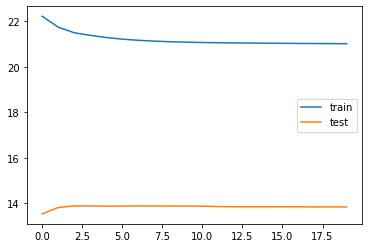

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [62]:
res = model.predict(X_te_reshaped)

In [63]:
test_data["DL_PRED"] = res
# test_data['DEP_DELAY_SCALED'] = dep_delay_tescaled

In [64]:
np.sqrt(mean_squared_error(test_data.DEP_DELAY,test_data.DL_PRED))

39.52054976733566

In [65]:
# keras_show = TimeSeries(test_data,x="FL_DATE",y=["DEP_DELAY","DL_PRED"],legend=True,plot_width=900, plot_height=350)
# show(keras_show)
sep_30m = test_data[test_data.FL_DATE >= pd.to_datetime("2019-11-29")]
# sep_30m = sep_30m.sort_values(by='FL_DATE',ascending=True)
sep_30m.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DL_PRED
236869,2019-11-29 00:23:00,14107,83,12478,71,00:23:00,00:20:00,-3.0,04:59:00,06:05:00,66.0,0.0,0.0,276.0,345.0,224.0,1.0,2153.0,0,0,0,25.0,94.0,3.0,-7.0,-3.0,-0.038200
236870,2019-11-29 00:30:00,12892,57,12478,71,00:30:00,00:21:00,-9.0,05:50:00,05:30:00,-20.0,0.0,0.0,320.0,309.0,284.0,1.0,2475.0,0,0,0,-3.0,25.0,94.0,3.0,-7.0,-1.266322
236871,2019-11-29 02:50:00,14843,101,12478,71,02:50:00,02:36:00,-14.0,06:39:00,06:48:00,9.0,0.0,0.0,229.0,252.0,228.0,1.0,1598.0,0,0,0,-9.0,-3.0,25.0,94.0,3.0,-1.289126
236872,2019-11-29 02:55:00,14025,85,11697,37,02:55:00,02:50:00,-5.0,06:22:00,06:21:00,-1.0,0.0,0.0,207.0,211.0,160.0,1.0,1334.0,0,0,1,-14.0,-9.0,-3.0,25.0,94.0,-2.193898
236873,2019-11-29 03:19:00,14254,86,12478,71,03:19:00,03:16:00,-3.0,07:18:00,07:28:00,10.0,0.0,0.0,239.0,252.0,234.0,1.0,1617.0,0,0,0,-5.0,-14.0,-9.0,-3.0,25.0,-2.618667


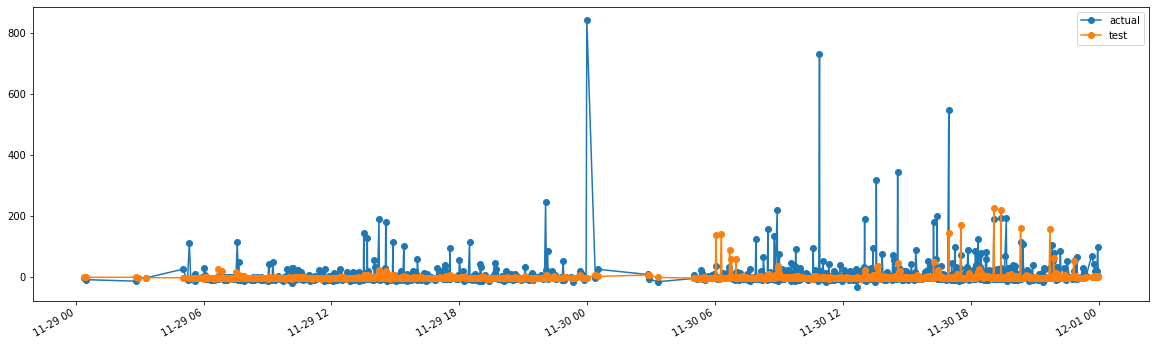

In [67]:
plt.figure(figsize=(20,6))
plt.plot_date(sep_30m['FL_DATE'], sep_30m['DEP_DELAY'], label='actual', linestyle ='solid')
plt.plot_date(sep_30m['FL_DATE'], sep_30m['DL_PRED'], label='test', linestyle ='solid')
plt.gcf().autofmt_xdate()
plt.legend()

In [ ]:
p = figure(plot_width=950, plot_height=400, x_axis_type="datetime")

# add a line renderer
p.multi_line([sep_30m['FL_DATE'], sep_30m['FL_DATE']], [sep_30m['DL_PRED'], sep_30m['DEP_DELAY_SCALED']], 
             color=["blue", "firebrick"], alpha=[0.8, 0.3], line_width=2, legend_label='pred')
# p.line(sep_30m['FL_DATE'], sep_30m['DL_PRED'], line_width=2, legend_label='pred')
# p.line(sep_30m['FL_DATE'], sep_30m['DEP_DELAY'], line_width=2, color='red', legend_label='actual')
p.legend.location = "top_left"
p.legend.click_policy="hide"

show(p)

In [ ]:
sep_30m